In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import uuid
import itertools


In [2]:
uniqueid = uuid.uuid4().int & (1 << 64)-1


In [3]:
use_pre_trained_embeds = False

In [4]:
# dataset_dir = "imdb"
dataset_dir = "sentiment140"
# dataset_dir = "coronaNLP"

model_dir = "models"
visuals_dir = "visuals"

# load a preprocessed dataframe see: (https://github.com/3nws/twitter-text-classification/blob/main/notebooks/process_dataframes.ipynb)
df = joblib.load(f"../dataframes/df_{dataset_dir}.pkl") 

In [5]:
df.columns=["text", "sentiment"]

In [6]:
df = df[730000:850000] if dataset_dir == "sentiment140" else df

In [7]:
df.shape

(120000, 2)

In [8]:
df.head()

,text,sentiment
738866,tummi ach,0
738867,fallen well hope stay happi pill,0
738868,english coursework,0
738869,hous clean chicken marin run befor spend even ...,0
738870,one day week get sleep dont get,0


C:\Users\Enes\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

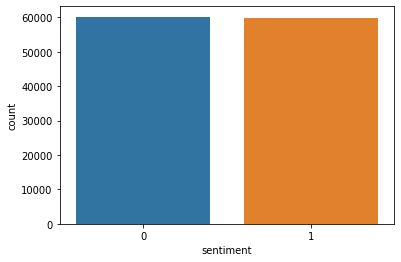

In [9]:

import seaborn as sns

sns.countplot(df.sentiment)


In [10]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.text)


In [11]:
len(counter)

64704

In [12]:
counter

Counter({'tummi': 139,
         'ach': 159,
         'fallen': 28,
         'well': 3417,
         'hope': 3495,
         'stay': 715,
         'happi': 2096,
         'pill': 34,
         'english': 230,
         'coursework': 48,
         'hous': 930,
         'clean': 479,
         'chicken': 161,
         'marin': 10,
         'run': 750,
         'befor': 993,
         'spend': 335,
         'even': 1716,
         'work': 6629,
         'may': 644,
         'treat': 109,
         'dvd': 140,
         'though': 1756,
         'one': 4438,
         'day': 7861,
         'week': 2101,
         'get': 8329,
         'sleep': 2351,
         'dont': 5166,
         'izzi': 10,
         'ur': 923,
         'ground': 61,
         'proofread': 3,
         'alex': 75,
         'first': 1330,
         'chapter': 55,
         'im': 13182,
         'allow': 151,
         'show': 1509,
         'page': 309,
         'noth': 769,
         'els': 414,
         'yet': 1015,
         'realli': 3847,

In [13]:
counter.most_common(5)

[('im', 13182), ('go', 10261), ('get', 8329), ('day', 7861), ('good', 6895)]

In [14]:
num_unique_words = len(counter)

In [15]:
# Split dataset into training and validation set

from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 0], df.iloc[:, 1]

train_sentences, val_sentences, train_labels, val_labels = train_test_split(X, y, test_size=0.3, stratify=y ,random_state=42)

train_sentences = train_sentences.to_numpy()
val_sentences = val_sentences.to_numpy()
train_labels = train_labels.to_numpy()
val_labels = val_labels.to_numpy()


In [16]:
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape


((84000,), (36000,), (84000,), (36000,))

In [17]:
type(train_sentences), type(val_sentences), type(train_labels), type(val_labels),

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [18]:
train_sentences[:1], train_labels[:1]

(array(['yes need optim dure time cant give'], dtype=object), array([1]))

In [19]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

max_features = 50000
# max_features = num_unique_words

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [20]:
# each word has unique index
word_index = tokenizer.word_index

In [21]:
word_index

{'im': 1,
 'go': 2,
 'get': 3,
 'day': 4,
 'good': 5,
 'work': 6,
 'like': 7,
 'love': 8,
 'today': 9,
 'dont': 10,
 'time': 11,
 'cant': 12,
 'one': 13,
 'got': 14,
 'want': 15,
 'thank': 16,
 'miss': 17,
 'know': 18,
 'back': 19,
 'feel': 20,
 'think': 21,
 'realli': 22,
 'u': 23,
 'lol': 24,
 'see': 25,
 'hope': 26,
 'well': 27,
 'make': 28,
 'need': 29,
 'still': 30,
 'new': 31,
 'amp': 32,
 'look': 33,
 'night': 34,
 'come': 35,
 'twitter': 36,
 'watch': 37,
 '2': 38,
 'much': 39,
 'sad': 40,
 'oh': 41,
 'home': 42,
 'morn': 43,
 'great': 44,
 'last': 45,
 'wish': 46,
 'ill': 47,
 'sleep': 48,
 'wait': 49,
 'tomorrow': 50,
 'bad': 51,
 'onli': 52,
 'follow': 53,
 'tri': 54,
 'right': 55,
 'week': 56,
 'happi': 57,
 'would': 58,
 'veri': 59,
 'haha': 60,
 'thing': 61,
 'whi': 62,
 'say': 63,
 'sorri': 64,
 'didnt': 65,
 'fun': 66,
 'take': 67,
 'nice': 68,
 'friend': 69,
 'ive': 70,
 'way': 71,
 'better': 72,
 'gonna': 73,
 'could': 74,
 'even': 75,
 'though': 76,
 'peopl': 77,
 't

In [22]:
len_of_vocab = len(word_index)

In [23]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [24]:
print(train_sentences[14:15])
print(train_sequences[14:15])

['work today like everi day life ok today im watch game high recommend fantast movi']
[[6, 9, 7, 327, 4, 100, 114, 9, 1, 37, 223, 513, 1109, 811, 158]]


In [25]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = max([len(text) for text in train_sequences]) if dataset_dir == "sentiment140" else 50
max_length

32

In [26]:

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((84000, 32), (36000, 32))

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_padded, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_padded, val_labels))


In [28]:
len(train_dataset), len(val_dataset)


(84000, 36000)

In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [30]:
train_dataset, val_dataset


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [31]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [32]:
reverse_word_index

{1: 'im',
 2: 'go',
 3: 'get',
 4: 'day',
 5: 'good',
 6: 'work',
 7: 'like',
 8: 'love',
 9: 'today',
 10: 'dont',
 11: 'time',
 12: 'cant',
 13: 'one',
 14: 'got',
 15: 'want',
 16: 'thank',
 17: 'miss',
 18: 'know',
 19: 'back',
 20: 'feel',
 21: 'think',
 22: 'realli',
 23: 'u',
 24: 'lol',
 25: 'see',
 26: 'hope',
 27: 'well',
 28: 'make',
 29: 'need',
 30: 'still',
 31: 'new',
 32: 'amp',
 33: 'look',
 34: 'night',
 35: 'come',
 36: 'twitter',
 37: 'watch',
 38: '2',
 39: 'much',
 40: 'sad',
 41: 'oh',
 42: 'home',
 43: 'morn',
 44: 'great',
 45: 'last',
 46: 'wish',
 47: 'ill',
 48: 'sleep',
 49: 'wait',
 50: 'tomorrow',
 51: 'bad',
 52: 'onli',
 53: 'follow',
 54: 'tri',
 55: 'right',
 56: 'week',
 57: 'happi',
 58: 'would',
 59: 'veri',
 60: 'haha',
 61: 'thing',
 62: 'whi',
 63: 'say',
 64: 'sorri',
 65: 'didnt',
 66: 'fun',
 67: 'take',
 68: 'nice',
 69: 'friend',
 70: 'ive',
 71: 'way',
 72: 'better',
 73: 'gonna',
 74: 'could',
 75: 'even',
 76: 'though',
 77: 'peopl',
 78

In [33]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [34]:
decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[451, 6, 246]
boo work sunday


In [35]:
embedding_dim = 64
lstm_dim = int(embedding_dim/2)

if use_pre_trained_embeds:
    embeddings_dictionary = dict()
    glove_file = open('../embeds/glove.6B.300d.txt', 'rb')

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

    glove_file.close()

    embeddings_matrix = np.zeros((num_unique_words, embedding_dim))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embeddings_matrix[index] = embedding_vector


In [36]:
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, SpatialDropout1D, Dropout, GlobalMaxPool1D, GlobalMaxPool2D
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2
from keras import Model

In [37]:
# 'softmax' activation function returns a probability distribution
# Binary for 0-1, Categorical for 2 or more classes, SparseCategorical for when labels are integers
# Dropout is used to prevent overfitting by randomly setting inputs to 0 at a low rate
# For stacked LSTMs set return_sequences to True except for the last one
# trainable parameter in Embedding layer should still be set to True when using already trained weights (it is by default anyway)

# 0
def one():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                        input_length=max_length, name="embeddinglayer", weights=[embeddings_matrix], trainable=True))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3)))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(learning_rate=0.001)
    metrics = [
        "accuracy",
        "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 1
def two():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                               input_length=max_length, name="embeddinglayer"))
    model.add(LSTM(embedding_dim, dropout=0.1))
    model.add(Dense(1, activation="sigmoid"))
    loss = BinaryCrossentropy(from_logits=False)
    optim = Adam(learning_rate=0.001)
    metrics = [
        "accuracy",
        "binary_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model
    
# 2
def three():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                               input_length=max_length, name="embeddinglayer"))
    model.add(LSTM(embedding_dim, dropout=0.1))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(learning_rate=0.001)
    metrics = [
        "accuracy",
        "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 3
def four():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                               input_length=max_length, name="embeddinglayer"))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.2)))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(learning_rate=0.001)
    metrics = [
        "accuracy",
        # "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 4
def five():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                        input_length=max_length, name="embeddinglayer"))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3)))
    model.add(Dense(32, activation="relu", kernel_regularizer=L1(0.01), activity_regularizer=L2(0.01)))
    model.add(Dense(2, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(learning_rate=0.0001)
    metrics = [
        "accuracy",
        "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 5
def six():
    model = tf.keras.Sequential()
    model.add(Embedding(
        max_features, embedding_dim, input_length=max_length))
    model.add(SpatialDropout1D(0.4))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.05, recurrent_dropout=0.2)))
    model.add(Dense(2, activation='softmax'))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(learning_rate=0.001)
    metrics = ["accuracy",
               "sparse_categorical_accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 6
def seven():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                        input_length=max_length, name="embeddinglayer"))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3)))
    model.add(Dense(32, activation="relu", kernel_regularizer=L1(0.01),
                    activity_regularizer=L2(0.01)))
    model.add(Dense(1, activation="sigmoid"))
    loss = BinaryCrossentropy(from_logits=False)
    optim = Adam(learning_rate=1e-4)
    metrics = [
        "accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 7
def eight():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.05))
    model.add(Dense(1, activation="sigmoid"))
    loss = BinaryCrossentropy(from_logits=False)
    optim = Adam(learning_rate=1e-4)
    metrics = [
        "accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

# 8
def nine():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                        input_length=max_length, name="embeddinglayer"))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_dim, dropout=0.3)))
    model.add(Dense(32, activation="relu", kernel_regularizer=L1(0.01),
                    activity_regularizer=L2(0.01)))
    model.add(Dense(5, activation="softmax"))
    loss = SparseCategoricalCrossentropy(from_logits=False)
    optim = Adam(learning_rate=1e-4)
    metrics = [
        "accuracy",
    ]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model


In [38]:
max_features, embedding_dim, max_length


(50000, 64, 32)

In [39]:
models = [
    one,
    two,
    three,
    four,
    five,
    six,
    seven,
    eight,
    nine
]

model_to_use = -3

model_idx = 0 if use_pre_trained_embeds else model_to_use


In [40]:
model = models[model_idx]()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddinglayer (Embedding)  (None, 32, 64)            3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 32, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,251,777
Trainable params: 3,251,777
Non-

In [41]:
history = model.fit(train_dataset, epochs=3, batch_size=128, validation_data=val_dataset, verbose=1)


Epoch 1/3
1313/1313 [==============================] - 38s 25ms/step - loss: 2.0503 - accuracy: 0.6832 - val_loss: 1.1151 - val_accuracy: 0.7635
Epoch 2/3
1313/1313 [==============================] - 31s 24ms/step - loss: 0.7178 - accuracy: 0.7800 - val_loss: 0.5626 - val_accuracy: 0.7705
Epoch 3/3
1313/1313 [==============================] - 30s 23ms/step - loss: 0.5098 - accuracy: 0.8073 - val_loss: 0.5399 - val_accuracy: 0.7739


In [42]:
# For debugging purposes

outputs = [layer.output for layer in model.layers]

debug_model = Model(inputs=model.input,
                    outputs=outputs)
outputs

[<KerasTensor: shape=(None, 32, 64) dtype=float32 (created by layer 'embeddinglayer')>,
 <KerasTensor: shape=(None, 32, 64) dtype=float32 (created by layer 'bidirectional')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional_1')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>]

In [43]:

features = debug_model.predict(val_padded)


In [44]:


for feature, output in zip(features, outputs):
    print(output.name)
    print(feature.shape)
    print(feature[0][0])

embeddinglayer/embedding_lookup/Identity_1:0
(36000, 32, 64)
[-0.02024436 -0.00441706 -0.04642317  0.02161371 -0.03847501 -0.0285597
  0.02742464 -0.03176156 -0.03870255  0.04212406 -0.00098929  0.02878052
 -0.00217569 -0.04022777  0.04453176  0.0224382   0.00268705  0.00897784
  0.0278319  -0.04599925  0.0297842  -0.04235928  0.04323927 -0.03698295
  0.0227175   0.04402344 -0.038026    0.03758289  0.03284235  0.02893343
 -0.00632778  0.04633148  0.03772897 -0.00038725  0.04522188  0.0428732
 -0.02489677  0.03563258 -0.00293065 -0.00625542 -0.00934705  0.03401538
 -0.04161125  0.02348853  0.05599247 -0.00335374 -0.01044474 -0.01338549
 -0.00950995  0.04464514 -0.037392    0.00136882  0.01694184  0.04981809
 -0.01274631  0.02965413  0.01298972  0.04619445  0.02343836  0.02910945
  0.01469194  0.01549284  0.03403573  0.01440935]
bidirectional/concat:0
(36000, 32, 64)
[ 0.00064771  0.00069266 -0.00143249 -0.00122143 -0.0018309  -0.00644996
 -0.00384571  0.00260138 -0.00340808 -0.00032392 

In [45]:

val_loss, val_acc = model.evaluate(val_dataset)
val_loss, val_acc


563/563 [==============================] - 5s 10ms/step - loss: 0.5399 - accuracy: 0.7739


(0.5399395823478699, 0.7739166617393494)

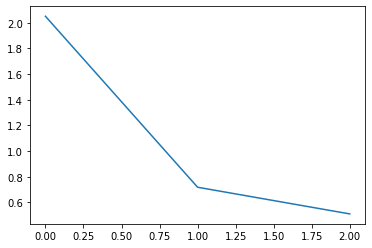

In [46]:
model_name = models[model_idx].__name__
model_export = f"NN_model_{model_name}_{uniqueid}_{val_acc}"
vis_dir = f'../{visuals_dir}/{model_export}'
model_save_dir = f'../{model_dir}/{model_export}'

# plotting training graph
plt.plot(history.history['loss'])
plt.savefig(f'{vis_dir}.png')


In [47]:
print(val_sentences[2])
print(val_labels[2])
print(model.predict(val_padded[2:3]))


well might like facebook uh fail quizz
0
[[0.38505214]]


In [48]:
val_predictions = model.predict(val_padded)

In [49]:
# Only for BinaryCrossentropy
predictions = [1 if p > 0.5 else 0 for p in val_predictions]
predictions

[1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,


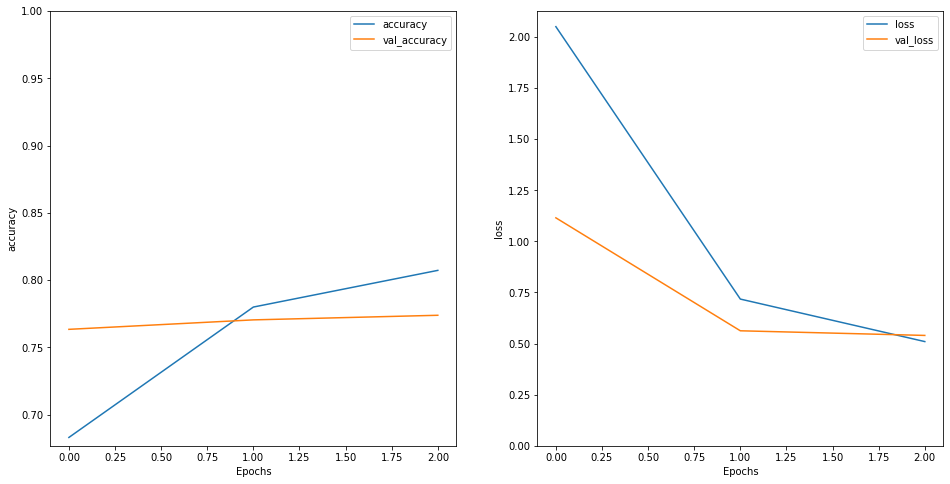

In [50]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig(f'{vis_dir}_loss_acc.png')


In [51]:
model.save(model_save_dir)


INFO:tensorflow:Assets written to: ../models/NN_model_seven_10612726913913796344_0.7739166617393494\assets


INFO:tensorflow:Assets written to: ../models/NN_model_seven_10612726913913796344_0.7739166617393494\assets


In [52]:
loaded_model = load_model(model_save_dir)


In [53]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddinglayer (Embedding)  (None, 32, 64)            3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 32, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,251,777
Trainable params: 3,251,777
Non-